# Simulate gamma ray sources in galaxy

In [157]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
rc('font',**{'family':'serif'})
rc('text',usetex=True)


##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm

##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004

Rsun = 8.3
hb = 10 #This is considered as high latitude

##This is for pulsars
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

In [158]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    "Deprecrated?"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

#Rtest = np.linspace(0,20)
#atest = [0.2,1.09,1.9]
#btest = [1.4,3.98,5.]
#for a in atest:
#    for b in btest:
#        plt.plot(Rtest,R_dep(Rtest,a,b),label='%s %s'%(a,b))
#        plt.ylim([0,10])

#plt.legend()
##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

def convertlb_px(l,b):
    "deprecrated?"
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)

    for m in classes:
        mask = (cls==m)|mask

    
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = catalog_spect.get_spec(fn)

    ave_spec = spec/np.amax(spec,axis=1)[:,None]
    ave_spec = ave_spec[mask]

    #for sp in ave_spec:
    #    plt.loglog(_E,sp,color='gray')
    ave_spec = 10**np.mean(np.log10(ave_spec),axis=0)
    
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])
    
    #print ind
        
    plotfunc = lambda E,a,b: b*(E)**-a
    #plt.loglog(E,plotfunc(E,ind,1),lw=5)
    
   # spec = plotfunc(E,ind,1)
    spec = ave_spec
    #plt.loglog(_E,spec)
    #plt.ylim([1e-15,1])
    good_spec = norm_spec(spec,total_flux,dE,mask_E)
    #print flux
    #print np.sum(good_spec[mask_E]*dE[mask_E])
    spec_normed = good_spec/np.max(good_spec)
    #plt.loglog(E,E**2*good_spec)
    return hist_3fgl,spec_normed,ind

[ 1.66162681  3.08326595  0.8945032 ]
[ 2622.68982573     3.40333088]


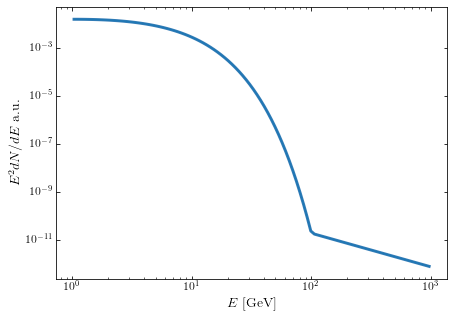

In [188]:
##Load 3fgl data and get average spectrum and histogram of fluxes from here
file_3fgl = 'gll_psc_v16.fit'
func_log = lambda E,p: p[0]*(E/p[1])**(-p[2]-p[3]*np.log(E/p[1]))
func_Exp = lambda E,p: p[0]*(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4])
#hist_3fgl_snr,intp_3fgl_snr_normed,snr_index = read_catalog('gll_psc_v16.fit',classes=['pwn','snr','spp'])
#hist_3fgl_psr,intp_3fgl_psr_normed,psr_index = read_catalog('gll_psc_v16.fit',classes=['psr'])

hist_3fgl_snr,intp_3fgl_snr_normed,snr_index = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['pwn','snr','spp','psr'])

hist_3fhl_snr,intp_3fhl_snr_normed,snr_index = read_catalog('gll_psch_v13.fit',catalog='fhl',
                                                          classes=['pwn','snr','spp','psr'])

#plt.loglog(E3fgl,E3fgl**2*intp_3fgl_snr_normed)
#plt.loglog(Efhl,Efhl**2*intp_3fhl_snr_normed)
f = lambda E,Ebr,p: p[0]*np.where(E <Ebr,(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4]),
                                  (Ebr/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(Ebr/p[3])**p[4])*(E/Ebr)**-p[5])
#plt.loglog(E3fgl,f(E3fgl,[1.,0.1,1.946,6,1,2.]))
Ebr = 100
fitter = lambda E,a,b,c: np.log10(func_Exp(E,[1,0.1,a,b,c]))
fit, cov = curve_fit(fitter,E3fgl,np.log10(intp_3fgl_snr_normed),p0=[2,6,1])
print fit
f2 = lambda E,p: p[0]*E**-p[1]
fitter2 = lambda E,a,b: np.log10(f2(E,[a,b]))
fit2,cov2 = curve_fit(fitter2,Efhl,np.log10(intp_3fhl_snr_normed),p0=[1,2.2])
print fit2
#plt.loglog(E3fgl,E3fgl**2*func_Exp(E3fgl,[1,0.1,fit[0],fit[1],fit[2]]),'bx')
#plt.loglog(Efhl,Efhl**2*f2(Efhl,[fit2[0],fit2[1]]),'rx')

fig,ax = plt.subplots(1,figsize=(7,5))

ax.loglog(E,E**2*f(E,Ebr,[1,0.1,fit[0],fit[1],fit[2],fit2[1]]),lw=3,color=c2)

ax.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=12,labelbottom='on')
ax.set_ylabel(r"$E^2 dN/dE$  a.u.",fontsize=14)
ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
plt.minorticks_on()
#ax.set_ylim([1e-9, 5e-5])
plt.savefig('unres_source_spec.pdf')

hist_3fgl_all,intp_3fgl_all_normed,ind = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['pwn','snr','spp','psr'])

intp_3fgl_all_normed = f(E,Ebr,[1,0.1,fit[0],fit[1],fit[2],fit2[1]])
ax.loglog(E,E**2*intp_3fgl_all_normed)
#intp_3fgl_all_normed = f(E,Ebr,[1,0.1,fit[0],fit[1],fit[2],fit2[1]])
#intp_3fgl_all_normed = f2(E,[1,2.2])
#plt.loglog(E,E**2*E**-2,'ko')
#fhl gll_psch_v13.fit
#intp_3fgl_snr_normed = func_Exp(E,[1,0.1,1.946123, 2.9145198,0.43158293]) #Average overal spec


In [160]:
###Load diffuse flux from skyfact fit

import open_dat

def read_datfile(datFile):
    "Read dat file and return total gas spec"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    
spec_diff_lb = []
diff_index_lb = []
spec_27_l = []
spec_dat = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    spec_dat.append(spec)
    mask_E_diff = E_diff > 2
    E_diff2 = E_diff
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    
    fit,cov = curve_fit(fitfunc,np.log10(E_diff),
                        np.log10(spec),sigma=error[mask_E_diff]/spec)
    
    ####
    ####This matters a lot!
    diff_index = fit[0]
    #print diff_index
   # plt.loglog(E_diff,E_diff**2*plotfunc(E_diff,fit[0],10**fit[1]))
   # plt.loglog(E_diff,E_diff**2*spec,
   #                       marker='.',linestyle='',label=ilb)
    fitted_spec = plotfunc(E,diff_index,10**fit[1]) ##If this is a softer spectra this matters a lot!
    spec_27 = plotfunc(E,2.7,10**fit[1])
    spec_diff_lb.append(fitted_spec)
    spec_27_l.append(spec_27)
   # print fit[0]
       # plt.loglog(E,E**2*fitted_spec)
        #plt.legend()
        

In [161]:
import open_dat
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
fit_rings_spec = []
fit_rings_spec_27 = []
fit_rings_err = []
dat_rings = open_dat.open_dat('r5_fulldisk_7rings3_spectra.dat')
deltaE = dat_rings['delta_e']
E_diff = dat_rings['emean']
mask_E_diff = E_diff > 2
Ec = 30
mask_2_30 = (E_diff <=Ec)&(E_diff>=2)
mask_30_200 = (E_diff>Ec)
#E_diff = E_diff[mask_E_diff]

diff_index = []
diff_index_2_30 = []
err_index_2_30 = []
diff_index_30_200 = []
err_index_30_200 = []

index_bay = np.loadtxt('index_r5_fulldisk_7rings3.dat')

def errfunc(theta,f,x,y,yerr):
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

from scipy import optimize

fitf = lambda *args: errfunc(*args)

modelfunc = lambda x,p: p[0]-p[1]*x

fitfunctie = lambda x,p1,p2: p1-p2*x

model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(fitfunc,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux))
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]


#f,ax = plt.subplots(1)
#ax.set_yscale('log')
#ax.set_xscale('log')
diff_index2 = []
err_index2 = []
for d in sorted(dat_rings):
    if 'Gas' in d and not 'err' in d:
        spec = dat_rings[d]/deltaE

        err =dat_rings[d+'_err']/deltaE
       # ax.set_ylim([1e-7,1e-5])
       # ax.errorbar(E_diff,E_diff**2*spec,yerr=E_diff**2*err,label=d)
        fit,cov = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff])
        fit2,cov2 = curve_fit(fitfunctie,np.log10(E_diff[mask_E_diff]),np.log10(spec[mask_E_diff]),
                              sigma=err[mask_E_diff]/(np.log10(10)*spec[mask_E_diff]),absolute_sigma=True)
        #print fit,cov
        #print fit2,cov2
        #res = optimize.minimize(fitf,p0,args=(modelfunc,E_diff[mask_30_200],
         #                                     spec[mask_30_200],err[mask_30_200]),method='BFGS')
        #print res

        fit27,cov27 = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff],model=model27,p0=[-7])
        
        fit_plot = plotfunc(E,fit[1],10**fit[0])
        
        #plt.loglog(E,E**2*plotfunc(E,2.7,10**fit27[0]),'*')
        #plt.loglog(E,E**2*plotfunc(E,fit[1],10**fit[0]))
        
        fit_rings_spec_27.append(plotfunc(E,2.7,10**fit27[0])) 
        fit_2_30,cov_2_30 = fit_index(E_diff[mask_2_30],spec[mask_2_30],err[mask_2_30])
        fit_30_200,cov_30_200 = fit_index(E_diff[mask_30_200],spec[mask_30_200],
                                          err[mask_30_200])
        
        diff_index2.append(fit2[1])
        err_index2.append(np.sqrt(cov2[1][1]))
        diff_index.append(fit[1])
        diff_index_2_30.append(fit_2_30[1])
        diff_index_30_200.append(fit_30_200[1])
        
        err_index_2_30.append(np.sqrt(cov_2_30[1,1]))
        err_index_30_200.append(np.sqrt(cov_30_200[1,1]))
        
        fit_rings_spec.append(fit_plot)
        err = np.sqrt(cov[1,1])
        fit_rings_err.append(err)
R_rings = [(0,1.7),(1.7,4.5),(4.5,6.5),(6.5,8.0),(8.0,10.0),(10.0,16.5),(16.5,50)]
R = np.array(R_rings)
#plt.legend()
#plt.ylim([2.2,3.1]);

#plt.errorbar(np.mean(R,axis=1),diff_index,
#             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=fit_rings_err,linestyle='',marker='o')
#plt.errorbar(np.mean(R,axis=1),diff_index2,
#             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_index2,linestyle='',marker='x')
#plt.errorbar(np.mean(R,axis=1),-index_bay[:,0],xerr=(np.mean(R,axis=1)-R[:,0]),yerr=index_bay[:,1],
#             marker='^',linestyle=' ')
#plt.errorbar(np.mean(R,axis=1),diff_index_2_30,
#             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_index_2_30,linestyle='',marker='s')
#plt.errorbar(np.mean(R,axis=1)+1,diff_index_30_200,
#             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_index_30_200,linestyle='',marker='s')

In [162]:
#Do the simulation of sources
def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
            SNR=False,PSR=False,f_t=5e-10,flux_cutoff=1e-20,spectrum=intp_3fgl_snr_normed):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)

    
    #f,ax = plt.subplots(1, figsize=(7,5))
 #   hist,bins = np.histogram(L_smpl, bins=np.logspace(34,39,50))
    #hist,bins = np.histogram(R_smpl,bins=np.arange(0,25))
    #mean_bins = (bins[0:-1]+bins[1:])/2.
    #ax.set_yscale('log',nonposy='clip')
    #ax.set_xscale('log',nonposx='clip')
    #ax.bar(bins[:-1],hist,width=1,color=c2,align='edge')
    #ax.set_xlabel(r'$R \ \mathrm{[kpc]}$')
    #ax.set_ylabel(r'Number of sources')
    
    #plt.savefig('R_hist_SNR.pdf')

        
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)

    
    
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    
    ##Fluxes at different R
    spec_R_unres = []
    for rr in R_rings:
        mask_R = (R_smpl >= rr[0])&(R_smpl < rr[1])
        total_flux_R = flux_data[mask_R]
        flux_R_unresolved = np.sum(total_flux_R[total_flux_R<f_t])

        spec_sim_R = norm_spec(spectrum,flux_R_unresolved,dE,mask_E)
        spec_R_unres.append(spec_sim_R)
        
    #Fluxes at different regions
    dict_flux_lb = {}
    dict_flux_lb['lb']=[]
    dict_flux_lb['flux100']=[]
    spec_unres = []
    frac = []
#     for ilb,_lb in enumerate(lb):
#         ll,bb = _lb
#         mask_l = np.abs(l)<=ll
#         mask_b = np.abs(b)<=bb
#         total_flux_lb = flux_data[mask_l&mask_b]
#         flux_unresolved = total_flux_lb[total_flux_lb<f_t]
#         flux_unresolved[flux_unresolved<flux_cutoff]=0
#         total_flux_unres = np.sum(flux_unresolved)
#         dict_flux_lb['lb'].append((ll,bb))
#         dict_flux_lb['flux100'].append(total_flux_unres)
#         if SNR:
#             spec_sim = norm_spec(intp_3fgl_snr_normed,total_flux_unres,dE,mask_E)
#         elif PSR:
#             spec_sim = norm_spec(intp_3fgl_psr_normed,total_flux_unres,dE,mask_E)
#         else:
#             print "no spec output"
#             spec_sim = 0
#         spec_sim = norm_spec(intp_3fgl_snr_normed,total_flux_unres,dE,mask_E)
#         diffuse = spec_diff_lb[ilb]
#         frac.append(spec_sim/diffuse)
#         spec_unres.append(spec_sim)

#     return hist,dict_flux_lb,frac,spec_unres,spec_R_unres
    return hist,spec_R_unres

In [190]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=5e-9,flux_cutoff = 1e-20,source_class='SNR',
                plothist=False,printstatements=False,alpha=alp_snr,beta=bet_snr,H=H_snr,
                hist_3fgl=hist_3fgl_snr,spectrum=intp_3fgl_snr_normed):

    print "Doing %s sample galaxys with %s sources,SNR_LF_i = %s, this might take some time..."%(Nsmpl,Nsnr,LF_i_snr)
    fluxes_snr = []

    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    spec_snr = []
    spec_R = []
    if source_class == 'SNR':
        SNR=True
        PSR = False
    elif source_class == 'PSR':
        PSR=True
        SNR=False
    else:
        
        print "unknown source class, use PSR or SNR"
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        hist_snr[i,:],ispec_R = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,SNR=SNR,PSR=PSR,f_t=ft,
                                                             flux_cutoff=flux_cutoff,spectrum=spectrum)
     
        #fluxes_snr.append(dict_snr['flux100'])
        #frac_snr.append(ifrac_snr)
        #spec_snr.append(ispec_snr)
        spec_R.append(ispec_R)
    #ave_frac_snr = np.average(frac_snr,axis=0)#For a roi a fraction for every E bin
    #std_frac_snr = np.std(frac_snr,axis=0)
    
    #ave_flux_snr = np.average(fluxes_snr,axis=0)
    #std_flux_snr = np.std(fluxes_snr,axis=0)

    ave_hist_snr = np.rint(np.mean(hist_snr,axis=0))
    std_hist_snr = (np.std(hist_snr,axis=0))
    
   # ave_spec_snr = np.average(spec_snr,axis=0)
   # std_spec_snr = np.std(spec_snr,axis=0)
    
    ave_spec_R = np.average(spec_R,axis=0)
    std_spec_R = np.std(spec_R,axis=0)
    
    mask_complete = (bins_mean > 1e-8)
    counts_snr = np.sum(ave_hist_snr[mask_complete])
    counts_3fgl_snr = np.sum(hist_3fgl[mask_complete])

    if plothist:
        print counts_snr, counts_3fgl_snr
        ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(8,8))
  
        ax1.loglog(bins_mean,ave_hist_snr,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)
        #ax1.set_yscale('log',nonposy='clip')
        #ax1.set_xscale('log',nonposx='clip')'
        ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=12,labelbottom='on')
        ax1.set_ylim([0.5,1e5])
        ax1.set_xlim([1e-13,1e-5])
        ax1.fill_between(bins_mean,ave_hist_snr-std_hist_snr,
                         ave_hist_snr+std_hist_snr,where=((ave_hist_snr-std_hist_snr)>0),facecolor=c3,alpha=0.2)
        ax1.fill_between(bins_mean,0,ave_hist_snr+std_hist_snr,where=(((ave_hist_snr-std_hist_snr)<=0)&(ave_hist_snr>0)),
                         facecolor=c3,alpha=0.2)
      
        ##Plot 3fgl
        ax1.loglog(bins_mean,hist_3fgl,marker='s',label='3FGL galactic sources (n=%s)'%np.sum(hist_3fgl),color=c4)

        #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
        ax1.set_xlabel(r'Flux from 1-100 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=12)
        ax1.set_ylabel('Number of sources',fontsize=12)

        ax1.legend(prop={'size':14},frameon=False,handlelength=2.3)
        plt.savefig('flux_counts_hist_3FGL.pdf')
        
#     return ave_frac_snr,ave_spec_snr,std_frac_snr,std_spec_snr,ave_spec_R,std_spec_R
    print "...done"
    return ave_spec_R,std_spec_R

Doing 50 sample galaxys with 29000 sources,SNR_LF_i = 1.8, this might take some time...
53.0 59
...done


/home/mart/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


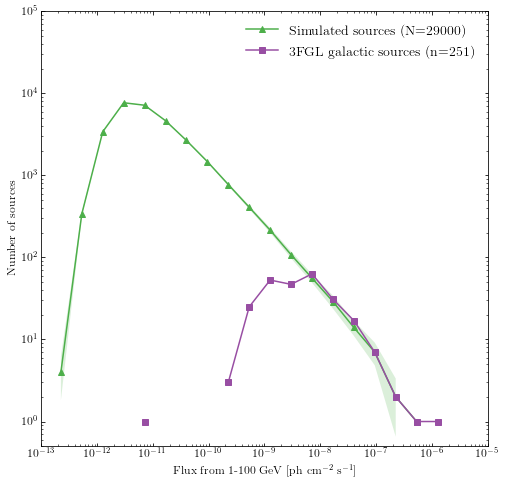

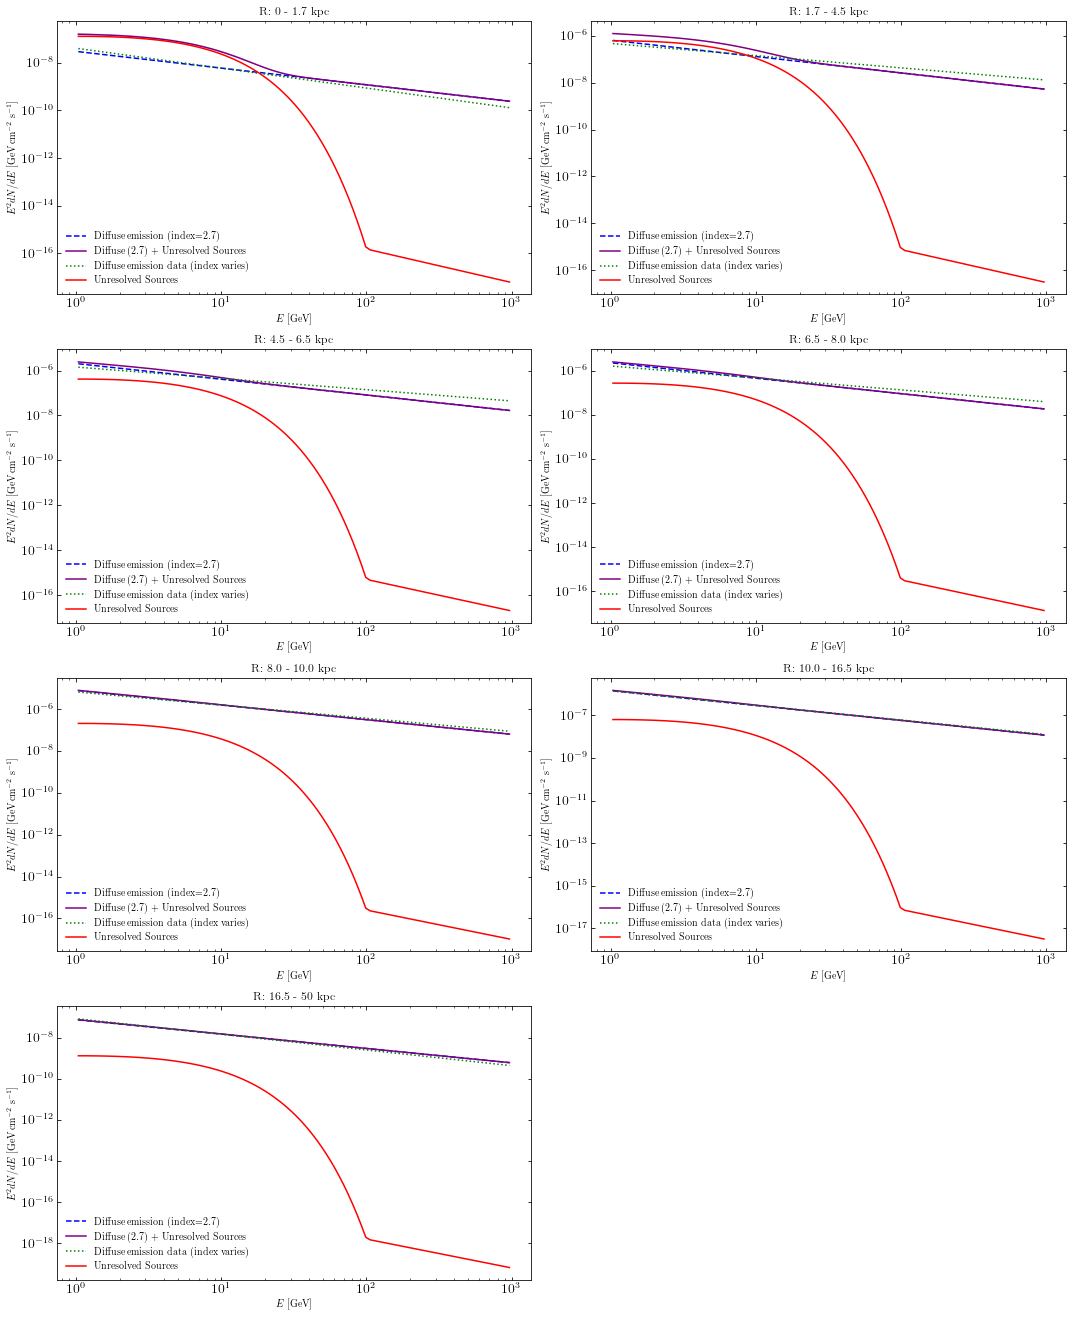

In [191]:
R_spec,std_R = ave_samples(50,Nsnr=29000,LF_i_snr=1.8,
                                            Lmin_snr=2e34,Lmax_snr=2e39,
                                           plothist=True,printstatements=False,
                           alpha=alp,beta=bet,H=H,hist_3fgl=hist_3fgl_all,spectrum=intp_3fgl_all_normed)


snr_spec_R = np.array(R_spec)
std_snr_spec_R = np.array(std_R)
fit_rings_spec = np.array(fit_rings_spec)

fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(4,2)
iE100 = np.argmin(E<100)

l_i_30 = []
l_i_200 = []
err_i_30 = []
err_i_200 = []
mask_E_2_30 = (E>=2)&(E<30)
mask_E_30_200 = (E>=30)&(E<230)
mask_E_2_200 = (E>=2)&(E<230)

for ri in range(len(R_rings)):
   #print "At abs(l,b):",lb[di]
    
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[ri])
    ax = plt.Subplot(fig,gs[ri]) 
    color = next(ax._get_lines.prop_cycler)['color']
    spec_sim_diff_unres = fit_rings_spec_27[ri]+snr_spec_R[ri]
    ax.loglog(E,E**2*fit_rings_spec_27[ri],label='Diffuse emission (index=2.7)',linestyle='--',color='b')
    ax.loglog(E,E**2*(spec_sim_diff_unres),label='Diffuse (2.7) + Unresolved Sources',linestyle='-',color='purple')
    ax.fill_between(E,E**2*(spec_sim_diff_unres-std_snr_spec_R[ri]),
                    E**2*(spec_sim_diff_unres+std_snr_spec_R[ri]),alpha=0.2,facecolor='purple')
    
    
    ax.loglog(E,E**2*fit_rings_spec[ri],linestyle=':',label='Diffuse emission data (index varies)',color='green')
    
    ax.loglog(E,E**2*snr_spec_R[ri],linestyle='-',label='Unresolved Sources',color='r')

    #ax.fill_between(E,E**2*(snr_spec_R[-1,ri]-std_snr_spec_R[-1,ri]),
    #                E**2*(snr_spec_R[-1,ri]+std_snr_spec_R[-1,ri]),alpha=0.2,facecolor='r')
    
    #index_30 = index(spec_sim_diff_unres,E,2,30)
    #index_200 = index(spec_sim_diff_unres,E,2,230)
    #index_2_200 = index(spec_sim_diff_unres,E,30,230)
    
    fit_2_30,cov_2_30 = fit_index(E[mask_E_2_30],spec_sim_diff_unres[mask_E_2_30],
                                  std_snr_spec_R[ri][mask_E_2_30])
    fit_30_200,cov_30_200 = fit_index(E[mask_E_30_200],spec_sim_diff_unres[mask_E_30_200],
                                      std_snr_spec_R[ri][mask_E_30_200])

    l_i_30.append(fit_2_30[1])
    err_i_30.append(np.sqrt(cov_2_30[1,1]))
    l_i_200.append(fit_30_200[1])
    err_i_200.append(np.sqrt(cov_30_200[1,1]))
    #print "spectral index 2-30GeV for diff(=2.7)+unres sources",fit_2_30[1]
    #print "spectral index 30-230GeV for diff(=2.7)+unres sources",fit_30_200[1]
    
   # for i,sf in enumerate(snr_spec_R):
   #     color = next(ax._get_lines.prop_cycler)['color']
        #ax.loglog(E,E**2*snr_spec_R[i,ri,:],color=color,label=options_print[i])
        
        #ax.fill_between(E,E**2*(snr_spec_R[i,ri,:]-std_snr_spec_R[i,ri,:]),
        #                E**2*(snr_spec_R[i,ri,:]+std_snr_spec_R[i,ri,:]),color=color,alpha=0.2)
   #     ax.set_xscale('log',nonposx='clip')

    #ax.set_ylim([1e-10,1e-5])
    
 

    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
   # plt.minorticks_on()
    ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$")
    ax.set_xlabel(r"$E$ [GeV]")
    ax.set_title('Full ROI')
    #ax.set_ylim([1e-11, 1e-4])

    
    ax.set_title('R: %s - %s kpc'%R_rings[ri])

    fig.add_subplot(ax)
    plt.legend(loc=0,frameon=False)
    #plt.savefig(fl[:-4]+'_GR.pdf',bbox_inches='tight')
##Plot legend in seperate subplot

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

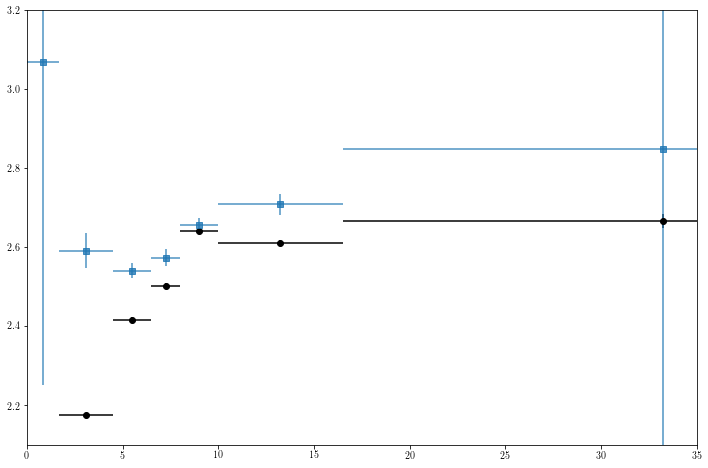

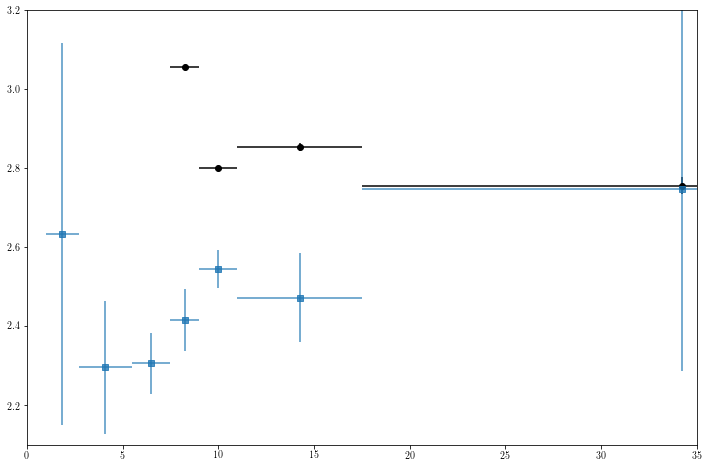

In [187]:
R = np.array(R_rings)
f,ax = plt.subplots(1)
ax.errorbar(np.mean(R,axis=1),l_i_30,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_i_30,
             color='black',marker='o',linestyle='',label='+unresolved PS')
ax.errorbar(np.mean(R,axis=1),diff_index_2_30,
             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_index_2_30,linestyle='',marker='s',alpha=0.8,label='data')

ax.set_xlim([0,35]);
ax.set_ylim([2.1,3.2]);

f2,ax2 = plt.subplots(1)
ax2.errorbar(np.mean(R,axis=1)+1,l_i_200,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_i_200,
             color='k',marker='o',linestyle='',label='+unresolved PS')
ax2.errorbar(np.mean(R,axis=1)+1,diff_index_30_200,
             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=err_index_30_200,linestyle='',marker='s',alpha=0.8,label='data')
ax2.set_xlim([0,35]);
ax2.set_ylim([2.1,3.2]);
#plt.ylim([-3.1,-2.1])
#plt.errorbar(np.mean(R,axis=1),diff_index,
#             xerr=(np.mean(R,axis=1)-R[:,0]),yerr=fit_rings_err,linestyle='',marker='s')



In [20]:
## Fix Nsnr and index LF snr
ind = 1.7
Nn = 30000

options_labels = ['Nsnr','LF_i_snr','Lmin_snr','Lmax_snr','alpha','beta','H','flux_cutoff','fermi_thres']
lmax = 5e38

options = [(10000,1.5,5e32,lmax),(10000,1.6,3e33,lmax),(150000,1.8,5e32,lmax),(100000,1.9,3e33,lmax),
           (10000,1.8,1.7e34,lmax),(30000,1.9,1.7e34,lmax),(60000,2.1,1.7e34,lmax),(6000,1.5,2e33,5e38),
          (15000,1.6,2e33,5e38),(30000,1.7,2e33,5e38),(70000,1.8,2e33,5e38),
           (160000,1.9,2e33,5e38),(300000,2.0,2e33,5e38),(600000,2.1,2e33,5e38)]

options = [(6000,1.5,3e33,5e38),(15000,1.6,3e33,5e38),(30000,1.7,3e33,5e38),(70000,1.8,3e33,5e38),
           (160000,1.9,3e33,5e38),(300000,2.0,3e33,5e38),(600000,2.1,2e33,5e38),(150000,2.0,6e33,5e38)] 

options = [(6000,1.5,3e33,5e38),(15000,1.6,3e33,5e38),(30000,1.7,3e33,5e38),(70000,1.8,3e33,5e38),
           (160000,1.9,3e33,5e38),(150000,2.0,6e33,5e38),(200000,1.6,1e32,1e38),(200000,2.1,1e34,1e38)]

options = []
Lmin = np.logspace(32,35,20)
Ind = np.arange(1.5,2.2,0.1)
Nn = 50000

for lmin in Lmin:
    for ind in Ind:
        options.append((Nn,ind,lmin,lmax))

options = [(Nn,1.5,1e32,5e38),(Nn,1.6,7e32,5e38),(Nn,1.7,2e33,lmax),(Nn,1.8,6e33,lmax),(Nn,1.9,1e34,lmax),
           (Nn,2.0,2e34,lmax),(Nn,2.1,3.5e34,lmax)]

Lmin = 2e34
Lmax = 2e38



options = [(43500,2.1,3e34,Lmax),(130000,2.1,1e34,Lmax),(2200,1.5,3e34,Lmax),(3500,1.5,1e34,Lmax),
           (14000,1.8,2e34,Lmax)]

#options = [(140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,5e-10),
#           (140000,2.1,1e34,Lmax,alp_snr,0.5*bet_snr,H_snr,5e-10),
#           (140000,2.1,1e34,Lmax,alp_snr,2*bet_snr,H_snr,5e-10)]

#options = [(140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,1e-10),
#           (140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,5e-10),
#           (140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,1e-9),
#           (140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,5e-11),
#           (140000,2.1,1e34,Lmax,alp_snr,bet_snr,H_snr,5e-9)]

#options=[(30000,1.7,1e34,1e38)]

snr_frac = []
options_print = []
snr_spec = []
snr_frac_std = []
snr_spec_std = []
snr_spec_R = []
std_snr_spec_R = []
for op in options:
    N,LF_i,Lmin,Lmax = op
    R_spec,std_R = ave_samples(10,Nsnr=N,LF_i_snr=LF_i,
                                            Lmin_snr=Lmin,Lmax_snr=Lmax,
                                           plothist=False,printstatements=False,source_class='SNR')
                                                                           #  alpha=1.9,beta=3.98)
   # ave_frac_psr,ave_spec_psr = ave_samples(10,N,LF_i,Lmin,Lmax,source_class='PSR',
   #                                         plothist=True,alpha=a,beta=b,H=h)
    options_print.append(op)
    #snr_frac.append(ave_frac_snr)
    #snr_spec.append(ave_spec_snr)
    #snr_frac_std.append(std_frac_snr)
    #snr_spec_std.append(std_spec_snr)
    snr_spec_R.append(R_spec)
    std_snr_spec_R.append(std_R)

#print snr_frac
print "done..."

Doing 10 sample galaxys with 43500 sources,SNR_LF_i = 2.1, this might take some time...
...done
Doing 10 sample galaxys with 130000 sources,SNR_LF_i = 2.1, this might take some time...
...done
Doing 10 sample galaxys with 2200 sources,SNR_LF_i = 1.5, this might take some time...
...done
Doing 10 sample galaxys with 3500 sources,SNR_LF_i = 1.5, this might take some time...
...done
Doing 10 sample galaxys with 14000 sources,SNR_LF_i = 1.8, this might take some time...
...done
done...


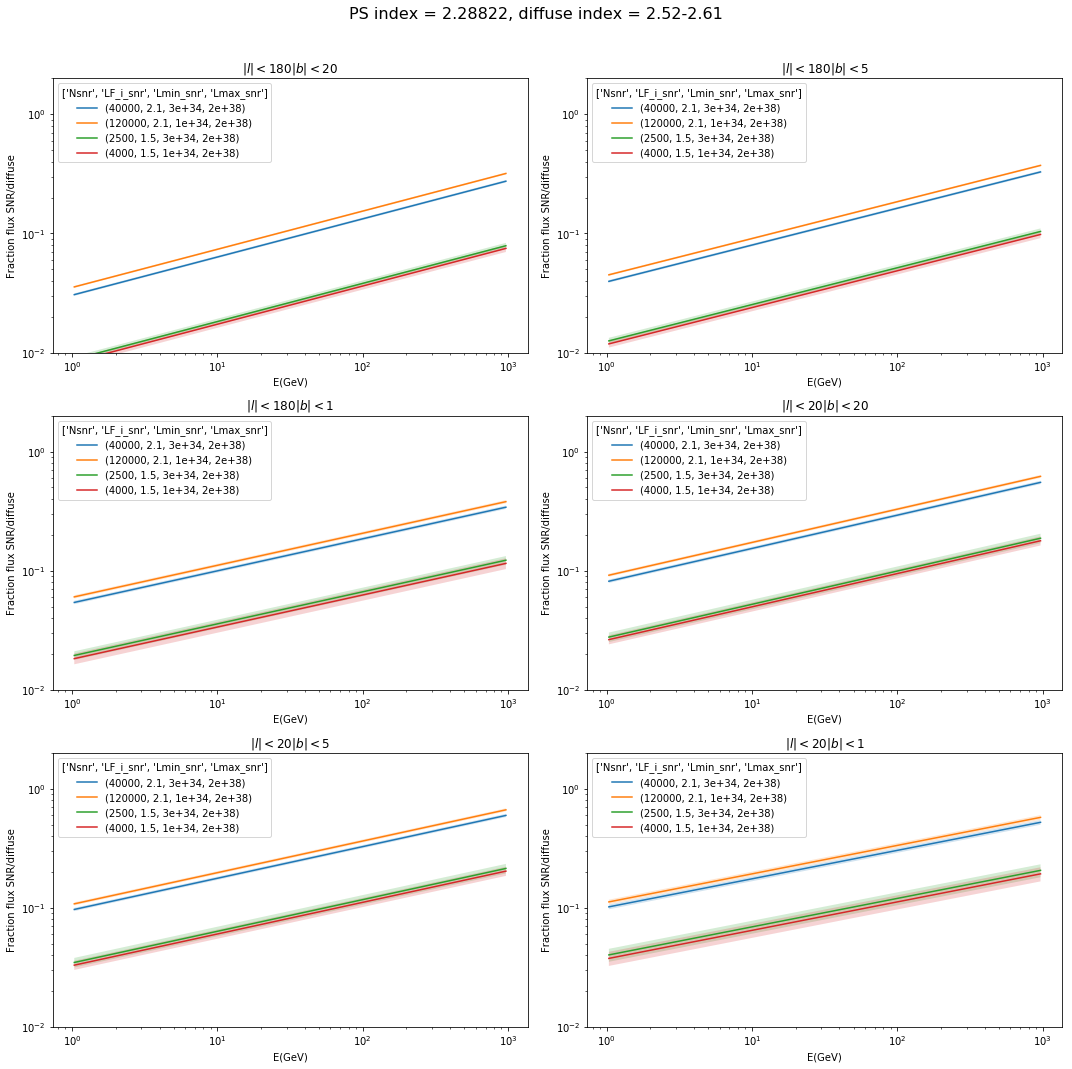

In [8]:
snr_frac = np.array(snr_frac)
snr_frac_std = np.array(snr_frac_std)
fig2 = plt.figure(figsize=(15,20))
gs2 = gridspec.GridSpec(4,2)
iE100 = np.argmin(E<100)

for di in range(len(spec_diff_lb)):
   #print "At abs(l,b):",lb[di]
    gsi2 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs2[di])
    ax2 = plt.Subplot(fig2,gs2[di]) 
    for i,sf in enumerate(snr_frac):
        #print options_print[i]
        div = snr_frac[i,di]
        ax2.loglog(E,div,label=options_print[i])
        ax2.fill_between(E,div-snr_frac_std[i,di],div+snr_frac_std[i,di],alpha=0.2)
        ax2.set_xscale('log',nonposx='clip')
        #print "At %.1f GeV the fraction is %.2f "%(E[iE100],div[iE100])
    ax2.set_ylim([0.01,2])
    ax2.set_title(r'$|l| < %s |b| < %s$'%lb[di])
    ax2.set_xlabel('E(GeV)')
    ax2.set_ylabel('Fraction flux SNR/diffuse')
    fig2.add_subplot(ax2)
    plt.legend(loc=2, title=options_labels[0:4])
##Plot legend in seperate subplot
fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fraction_ps_diffuse_1.pdf')

(4, 6, 100)
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.66721966614
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.62426528904
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.65931959245
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.60853812682
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.64721192419
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.58598839564
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.62560677127
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.54980846761
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.61471788006
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.53328118272
spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2) -2.61110442723
spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2) -2.52802272953


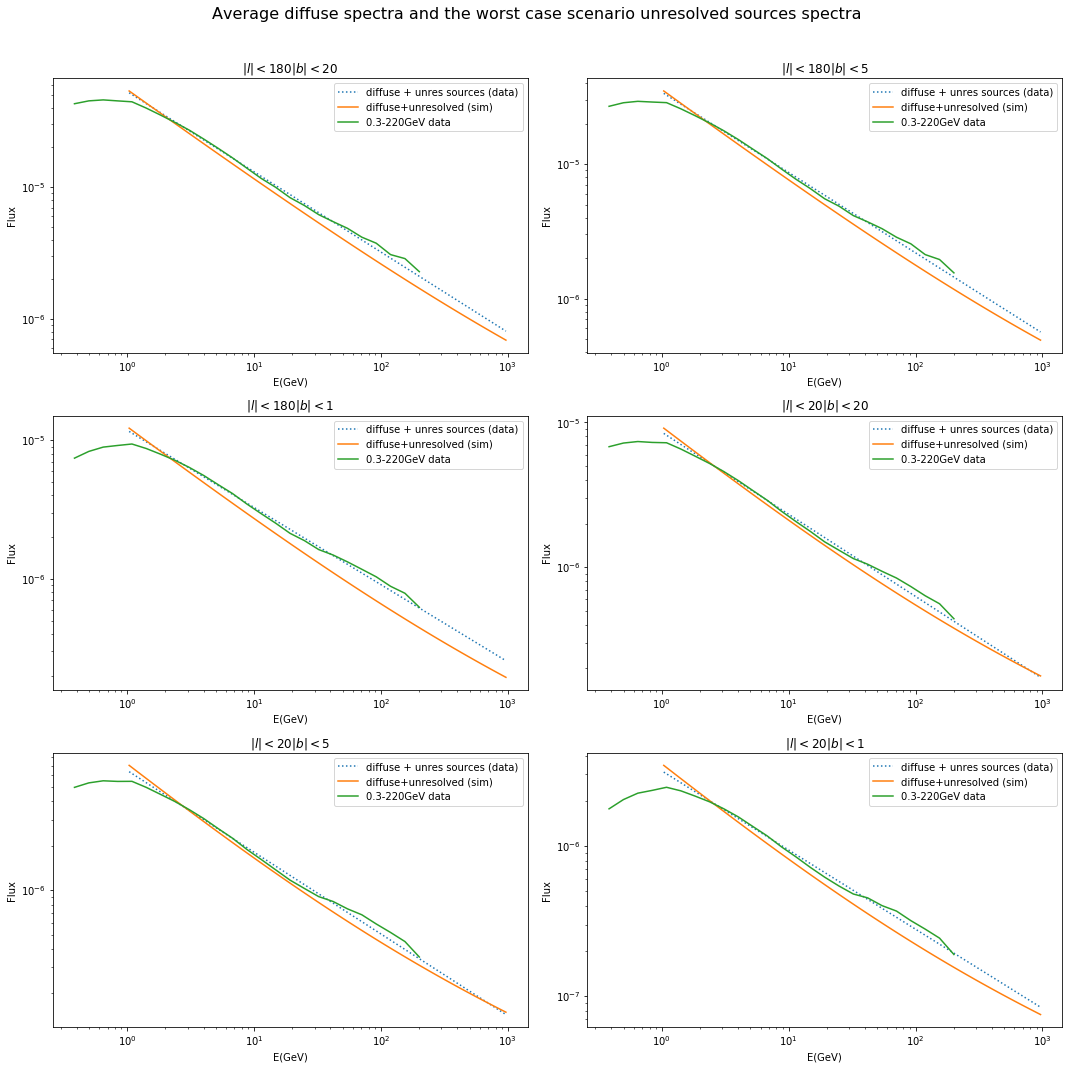

In [62]:
###Plot the fraction of unresolved/diffuse emission
snr_spec = np.array(snr_spec)
snr_spec_std = np.array(snr_spec_std)

fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(4,2)
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)

def index(spec,E,Emin=1,Emax=100):
    logy = np.log10(spec)
    logx = np.log10(E)
    iEmin = np.argmax(E >= Emin)
    iEmax = np.argmax(E >= Emax)
    dy = logy[iEmin]-logy[iEmax]
    dx = logx[iEmin]-logx[iEmax]
    dydx = dy/dx

    return dydx



for di in range(len(spec_diff_lb)):
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(snr_spec):      
        spec = snr_spec[i,di]
        #ax.loglog(E,E**2*spec,label=options_print[i])
        
    spec_sim_diff_unres = spec_27_l[di]+snr_spec[1,di]
    ax.loglog(E,E**2*(spec_diff_lb[di]),label='diffuse + unres sources (data)',linestyle=':')
    #ax.loglog(E,E**2*(snr_spec[0,di]),label='unresolved',linestyle=':')
    ax.loglog(E,E**2*(spec_sim_diff_unres),label='diffuse+unresolved (sim)',linestyle='-')
    ax.loglog(E_diff2,E_diff2**2*(spec_dat[di]),label='0.3-220GeV data')
    #ax.fill_between(E,E**2*(snr_spec[0,di]-snr_spec_std[0,di]),E**2*(snr_spec[0,di]+snr_spec_std[0,di]),alpha=0.2)

    
    ########
    ########
    ##Make a fit to the diff+unres(sim) to measure index
    ############3
    #########
    #fit,cov = curve_fit(fitfunc,np.log10(E),
     #                   np.log10(spec_sim_diff_unres))
    #ax.loglog(E,E**2*plotfunc(E,fit[0],10**fit[1]),label='fit')

    print "spectral index 2-30GeV for diff(=2.7)+unres sources(=2.2)",index(spec_sim_diff_unres,E,2,30)
    print "spectral index 30-230GeV for diff(=2.7)+unres sources(=2.2)",index(spec_sim_diff_unres,E,30,230)
    #ax.set_ylim([0.001,1])
    ax.set_title(r'$|l| < %s |b| < %s$'%lb[di])
    ax.set_xlabel('E(GeV)')
    ax.set_ylabel('Flux')
    fig.add_subplot(ax)
    plt.legend(loc=1)#, title=options_labels[0:4])
##Plot legend in seperate subplot
fig.suptitle(r'Average diffuse spectra and the worst case scenario unresolved sources spectra',fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('spectra')